# Food Vision foof101

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training


## Check GPU
[TensorFlow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision) for more details.

In [1]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-675f97c0-7f98-6b94-50a5-32df8d247c37)


In [2]:
# TensorFlow version 2.13 is available in tf-nightly as of May 2023 (will be default in Google Colab soon).
# Therefore, to prevent errors we'll install tf-nightly first.
# See more here: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/550

# Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.6 MB/s eta 0:00:00


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


TensorFlow version: 2.15.0-dev20230817
Notebook last run (end-to-end): 2023-08-18 18:04:01.072767


## Get helper functions

We've created a series of helper functions throughout the previous notebooks in the course. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [3]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-08-18 18:04:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-18 18:04:01 (86.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.


In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [6]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False`
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [7]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteH8XUGZ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteH8XUGZ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, **note:** this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the `"label"` key.

In [8]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it.

In [10]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [11]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 97
  Class name (str form): takoyaki
        


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [13]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[162, 140, 117],
        [164, 142, 119],
        [169, 147, 126],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[168, 146, 123],
        [170, 148, 125],
        [176, 154, 131],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[173, 151, 128],
        [176, 154, 131],
        [182, 160, 137],
        ...,
        [  4,   4,   

In [14]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format,

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

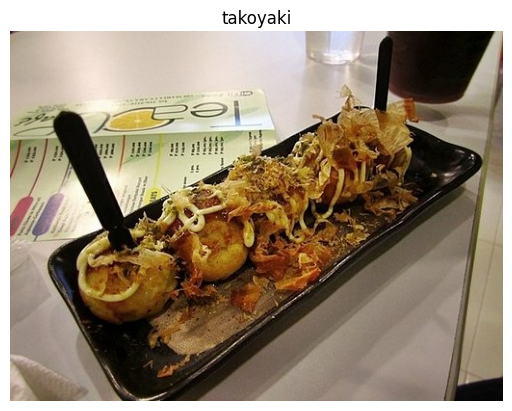

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions for our data

our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure `(image, label)`.

Let's try our function out on a target image.

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 54  30  26]
  [ 57  33  29]
  [ 72  49  43]
  ...
  [192 184 163]
  [190 179 159]
  [181 169 147]]

 [[ 51  28  22]
  [ 60  37  31]
  [ 81  58  52]
  ...
  [191 183 162]
  [189 176 157]
  [176 164 142]]]...,
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 56.23469   32.591835  27.877552]
  [ 98.16328   75.16328   68.50001 ]
  [121.62245  101.62245   91.63265 ]
  ...
  [191.72456  191.36736  170.93883 ]
  [202.18863  196.9743   176.90286 ]
  [185.918    174.10167  153.6169  ]]

 [[ 93.47959   73.55102   64.19388 ]
  [144.57143  124.64286  113.561226]
  [169.66327  150.20409  138.79082 ]
  ...
  [196.22955  195.22955  176.80103 ]
  [202.02025  194.9335   175.87225 ]
  [182.24942  168.44324  148.72888 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

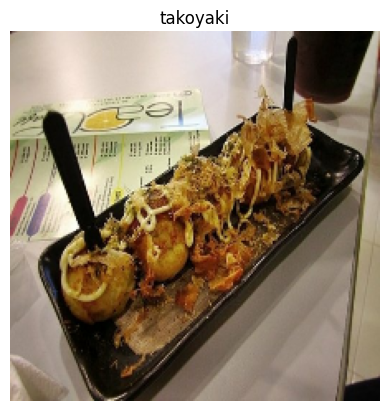

In [18]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

All this food visualization is making me hungry. How about we start preparing to model it?

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches. Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

In [19]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

And now let's check out what our prepared datasets look like.

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Excellent! Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [21]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

## Setup mixed precision training

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

For tensors in float16 format, each element occupies 16 bits in computer memory.

(using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

In [22]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

In [23]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

Great, since the global dtype policy is now `"mixed_float16"` our model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Build feature extraction model

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png)
*Before fine-tuning, it's best practice to train a feature extraction model with custom top layers.*

* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

In [24]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 2s 0us/step


In [25]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [26]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [27]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

> 🔑 **Note:** The mixed precision API automatically causes layers which can benefit from using the `"mixed_float16"` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

## Fit the feature extraction model

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [28]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230818-181809
Epoch 1/3
2368/2368 [==============================] - 212s 82ms/step - loss: 1.7169 - accuracy: 0.5821 - val_loss: 1.1250 - val_accuracy: 0.6992
Epoch 2/3
2368/2368 [==============================] - 194s 80ms/step - loss: 1.1990 - accuracy: 0.6894 - val_loss: 1.0262 - val_accuracy: 0.7166
Epoch 3/3
2368/2368 [==============================] - 198s 82ms/step - loss: 1.0543 - accuracy: 0.7237 - val_loss: 0.9921 - val_accuracy: 0.7238


Nice, looks like our feature extraction model is performing pretty well. How about we evaluate it on the whole test dataset?

In [29]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 61s 76ms/step - loss: 0.9968 - accuracy: 0.7291


[0.9968328475952148, 0.7290692925453186]

accuracy of the model as shown in the above cell is 72.91%